# Tarea 2
### Ejercicio 3

## Jonathan Alexis Urrutia Anguiano 41401102-5

In [1]:
from pylab import *
%matplotlib inline

En este ejercicio se graficará la trayectoria que sigue una pelota al caer sobre un plano inclinado dadas las condiciones iniciales. Para resolver la ecuación diferencial se utilizará el método de Runge-Kutta de cuarto orden:

In [2]:
def rk4(ec,p_ini,x,args=0,h=0.01):
    if (x[1]-x[0]) <= 5.*h:
        h = (x[1]-x[0])/10
    tiempos = arange(x[0],x[1]+h,h)
    sol = zeros((len(tiempos),len(p_ini)))
    sol[0,:] = p_ini
    if args==0:
        for i in xrange(len(tiempos)-1):
            k1 = ec(sol[i,:],tiempos[i])
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h)
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h)
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h)
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
    else:
        for i in xrange(len(tiempos)-1):
            k1 = ec(sol[i,:],tiempos[i],args)
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h,args)
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h,args)
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h,args)
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
    return tiempos,sol

Sabemos que la ecuación de movimiento es la siguiente:
$$ m \ddot{\vec r} = -mg \hat{e_y} + fric(\dot{\vec{r}}),$$
donde $ fric(\dot{\vec{r}})$ es una función que depende únicamente de las velocidad. En este caso se asumirá que esta función es es una fuerza proporcional a la velocidad o bien, al cuadrado de la velocidad. Es decir:
$$ m \ddot{\vec r} = -mg \hat{e_y} + \gamma \dot{\vec{r}}   ---------- (1)\\
m \ddot{\vec r} = -mg \hat{e_y} + \gamma ||\dot{\vec{r}}|| \dot{\vec r}  --------- (2)
$$

Haciendo los cambios de variable $u_1 = x,\, u_2 = \dot x, \, v_1 = y\mbox{ y } v_2 = \dot y$, el sistema de ecuaciones a resolver es el siguiente:

$$
\left(\begin{array}{c}\dot u_1 \\ \dot v_1 \\ \dot u_2\\ \dot v_2\end{array}\right) = \left(\begin{array}{c} u_2 \\ v_2 \\ \frac{1}{m} fric(u_1)\\-g +\frac{1}{m} fric(v_1)\end{array}\right)
$$

Los modelos de fricción descritos en (1) y (2) y descompuestos en componentes son los siguientes:

In [100]:
def fric_v(v,gamma=0.1):
    f_x = gamma*v[0]
    f_y = gamma*v[1]
    return array([f_x,f_y]) 

def fric_v2(v,gamma=0.1):
    norm_v = sqrt(v[0]**2 + v[1]**2)
    f_x = gamma*norm_v*v[0]
    f_y = gamma*norm_v*v[1]
    return array([f_x,f_y]) 

La ecuación de movimiento a resolver(ya con la rotación) es:

In [101]:
def e_mov(r_v,t,fric=0, g=9.8,m=1):
    dx = r_v[2]
    dy = r_v[3]
    if fric == 0:
        dvx,dvy = 0,-g
    else:
        dvx = - fric([r_v[2],r_v[3]])[0]/m
        dvy = -g- fric([r_v[2],r_v[3]])[1]/m
    return array([dx,dy,dvx,dvy])

Recordemos que para el caso en el que la pelota cae y rebota al suelo (sin que tenga inclinación) la componente $y$ era reflejada al hacer contacto, mientras que la componente $x$ se mantenía invariente. Para el caso del plano inclinado lo que sucede es que la componente de la velocidad penpendicular al plano es la que se refleja y la paralela se mantiene invariante. Para poder simular esto, en la función \emph{rebote} que dará las nuevas condiciones al hacer ontacto con el \emph{plano}, las velocidades serán rotadas el ángulo de inclinación del plano mediante la transformación siguiente:

Con la transformación de coordenadas:
$$
\left(\begin{array}{c}x'\\y'\\\dot x'\\\dot y' \end{array}\right) = \left(\begin{array}{c c c c}1 & 0 & 0 & 0\\0& 1& 0 &0 \\0&0& \cos\theta & -\sin\theta\\0&0&\sin\theta & \cos\theta \end{array}\right) \left(\begin{array}{c}x\\y\\\dot x \\ \dot y \end{array}\right) 
$$

Además, las condiciones para el rebote ya no serán cuando la solución a la ecuación diferencial sea igual a cero, sino cuando esta solución menos la recta que simula el plano sea igual a cero.

In [102]:
def rot_vel(ang):
    ang = ang*pi/180.
    return array([1,0,0,0]),array([0,1,0,0]),array([0,0,cos(ang),-sin(ang)]),array([0,0,sin(ang),cos(ang)])

In [103]:
def plano(x,angulo):
    return -tan(angulo*pi/180.)*x

In [104]:
def rebote(r_v_i,mi_dt,ang,modelo_fric=0):
    dt_busqueda = mi_dt/2
    y_izq = r_v_i
    t,sol = rk4(e_mov,r_v_i,[0,dt_busqueda],modelo_fric)
    y_med = sol[-1,:]

    while abs(y_izq[1]-plano(y_izq[0],ang))>1e-5:
        if (y_izq[1]-plano(y_izq[0],ang))*(y_med[1]-plano(y_med[0],ang))<0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t, sol = rk4(e_mov, reinicio,[0,dt_busqueda],modelo_fric)
        y_izq = reinicio
        y_med = sol[-1,:]
    y_izq = dot(rot_vel(ang),y_izq)
    y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])
    return y_izq

Además vamos a definir una función que haga todo el cálculo y que regrese los datos sólo para graficar.

In [105]:
def datos_graf(cond_ini, ang, modelo_fric=0,pts=100, dt=0.1):
    N = pts
    inicio = cond_ini
    trayectoria = zeros((N,len(inicio)))
    mi_dt = dt
    trayectoria[0,:] = array(inicio)
    for i in range(N-1):
        t,sol_dt = rk4(e_mov,trayectoria[i,:],[0,mi_dt], modelo_fric)
    
        if sol_dt[-1,:][1]-plano(sol_dt[-1,:][0], ang) < 0:
            y_izq = rebote(trayectoria[i,:],mi_dt,ang)    
            trayectoria[i+1,:] = y_izq
        else:
            trayectoria[i+1,:] = sol_dt[-1,:]
    return trayectoria

###  a) y b)
Veremos el caso para el plano con un ángulo de $0^{\circ}$, $15^{\circ}$, $30^{\circ}$ y $45^{\circ}$  , con vel. iniciales positivas y con los modelos de fricción distintos y considerando el caso ideal de no fricción.

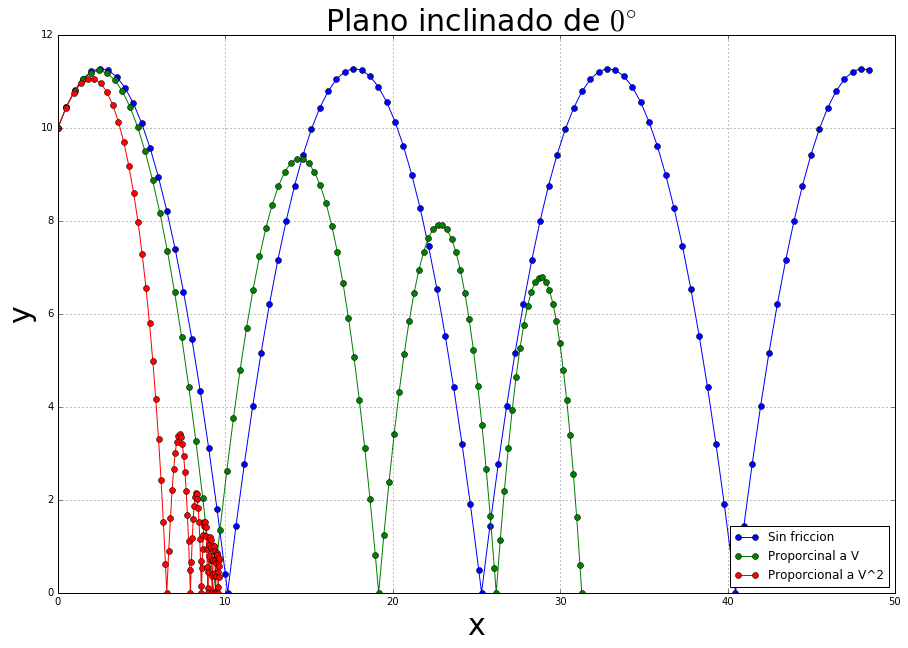

In [110]:
fig, ax = plt.subplots(figsize=(15, 10))
grid(True)
title(r' Plano inclinado de $0^{\circ}$',fontsize = 30),xlabel('x',fontsize=30),ylabel('y',fontsize = 30)

modelos = [0 , fric_v, fric_v2]
etiquetas = ['Sin friccion','Proporcinal a V','Proporcional a V^2']

for i in xrange(len(modelos)):
    trayectoria = datos_graf([0,10,5,5],0,modelos[i])
    plot(trayectoria[:,0],trayectoria[:,1],'o-', label = str(etiquetas[i]))
plot(trayectoria[:,0],plano(trayectoria[:,0],0))
ax.legend(loc='lower right')
show()

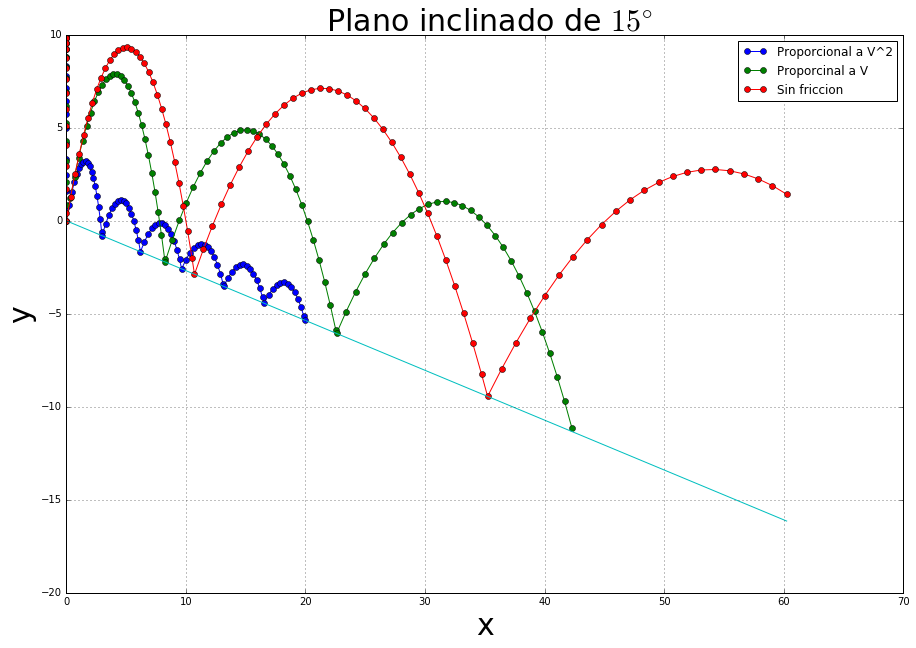

In [109]:
fig, ax = plt.subplots(figsize=(15, 10))
grid(True)
title(r' Plano inclinado de $15^{\circ}$',fontsize = 30),xlabel('x',fontsize=30),ylabel('y',fontsize = 30)

modelos = [0 , fric_v, fric_v2]
etiquetas = ['Sin friccion','Proporcinal a V','Proporcional a V^2']

for i in xrange(len(modelos)):
    trayectoria = datos_graf([0,10,0,0],15,modelos[2-i])
    plot(trayectoria[:,0],trayectoria[:,1],'o-',label = str(etiquetas[2-i]))
plot(trayectoria[:,0],plano(trayectoria[:,0],15))
ax.legend(loc='upper right')
show()



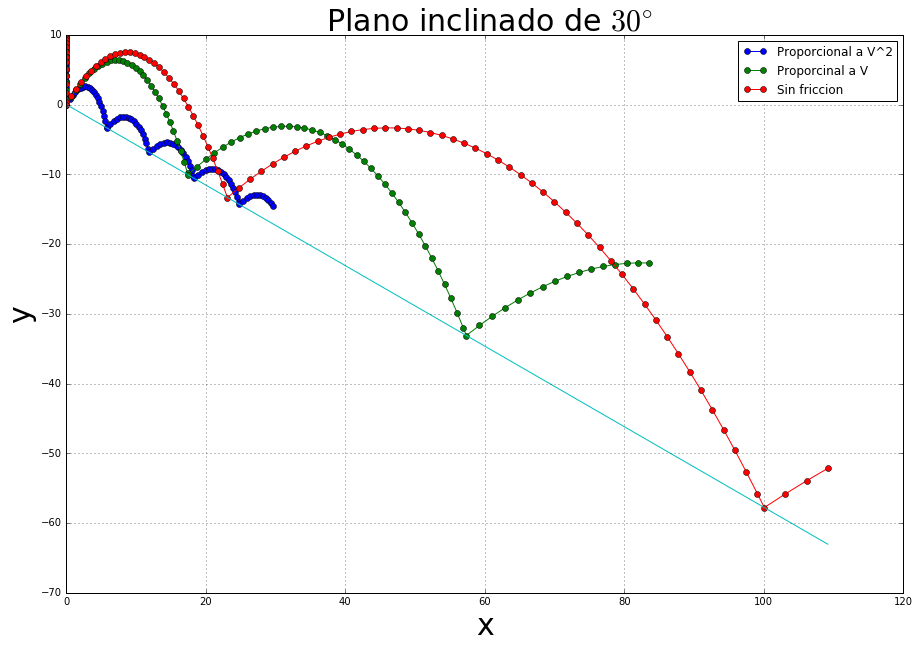

In [111]:
fig, ax = plt.subplots(figsize=(15, 10))
grid(True)
title(r' Plano inclinado de $30^{\circ}$',fontsize = 30),xlabel('x',fontsize=30),ylabel('y',fontsize = 30)

modelos = [0 , fric_v, fric_v2]
etiquetas = ['Sin friccion','Proporcinal a V','Proporcional a V^2']

for i in xrange(len(modelos)):
    trayectoria = datos_graf([0,10,0,0],30,modelos[2-i])
    plot(trayectoria[:,0],trayectoria[:,1],'o-',label = str(etiquetas[2-i]))
plot(trayectoria[:,0],plano(trayectoria[:,0],30))
ax.legend(loc='upper right')
show()

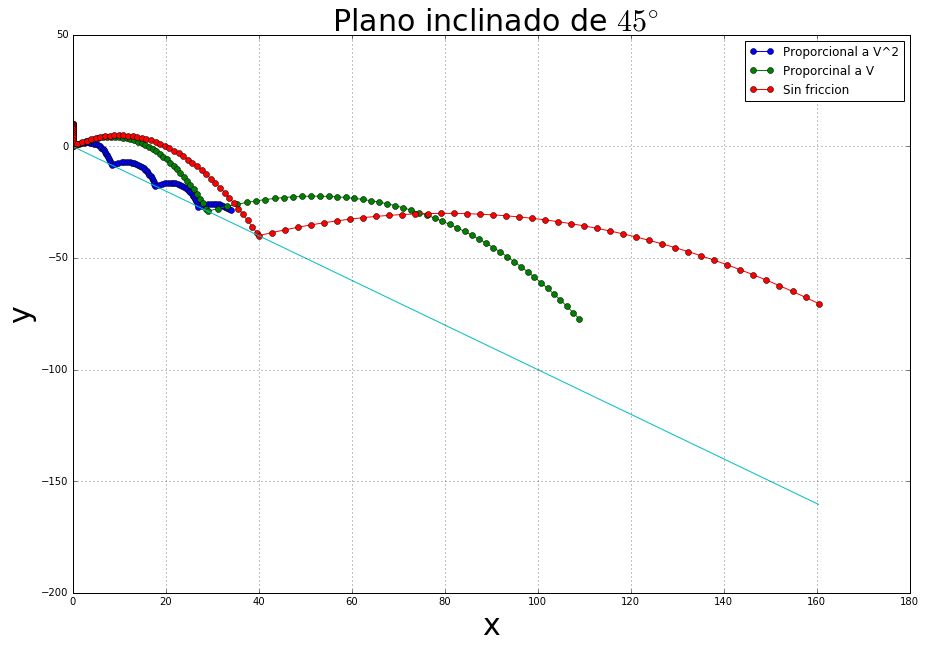

In [112]:
fig, ax = plt.subplots(figsize=(15, 10))
grid(True)
title(r' Plano inclinado de $45^{\circ}$',fontsize = 30),xlabel('x',fontsize=30),ylabel('y',fontsize = 30)

modelos = [0 , fric_v, fric_v2]
etiquetas = ['Sin friccion','Proporcinal a V','Proporcional a V^2']

for i in xrange(len(modelos)):
    trayectoria = datos_graf([0,10,0,0],45,modelos[2-i])
    plot(trayectoria[:,0],trayectoria[:,1],'o-',label = str(etiquetas[2-i]))
plot(trayectoria[:,0],plano(trayectoria[:,0],45))
ax.legend(loc='upper right')
show()

## c) 
Ahora queremos una velocidad inicial tale que cumpla
$$ \tan^{-1}\left(\frac{v_{0y}}{v_{0x}}\right)>\alpha, $$
con $\alpha = 15^\circ, 30^\circ, 45^\circ$

Para el primer caso se usarán los valores de $v_{0y}=v_{0x}=-5$, para el segundo caso se usarán los valores de $v_{0y}=v_{0x}=-10$. Para el tercer caso $v_{0y} = -10\, ,v_{0x} = -5$

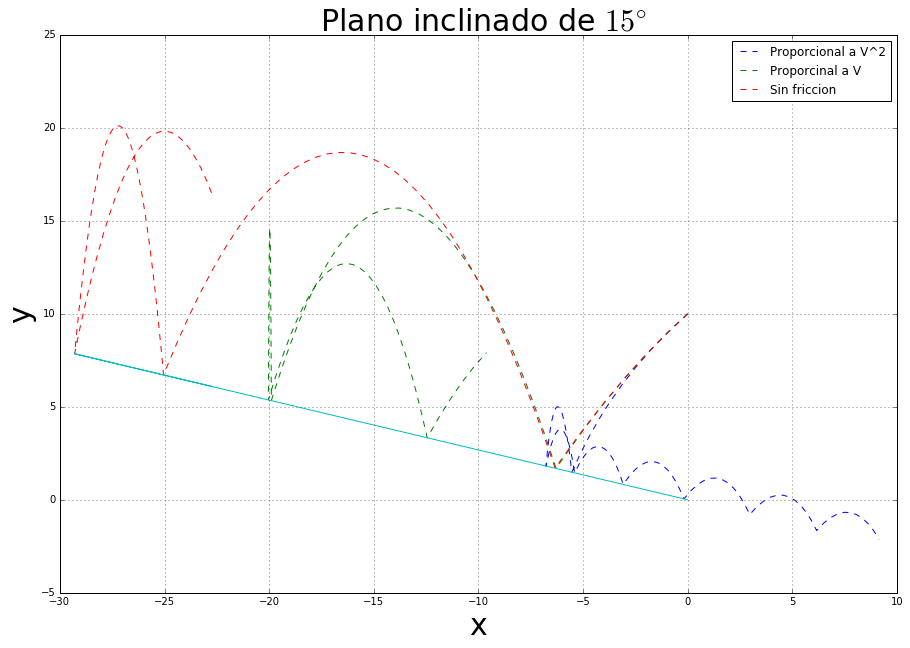

In [119]:
fig, ax = plt.subplots(figsize=(15, 10))
grid(True)
title(r' Plano inclinado de $15^{\circ}$',fontsize = 30),xlabel('x',fontsize=30),ylabel('y',fontsize = 30)

modelos = [0 , fric_v, fric_v2]
etiquetas = ['Sin friccion','Proporcinal a V','Proporcional a V^2']

for i in xrange(len(modelos)):
    trayectoria = datos_graf([0,10,-10,-10],15,modelos[2-i])
    plot(trayectoria[:,0],trayectoria[:,1],'--',label = str(etiquetas[2-i]))
plot(trayectoria[:,0],plano(trayectoria[:,0],15))
ax.legend(loc='upper right')
show()



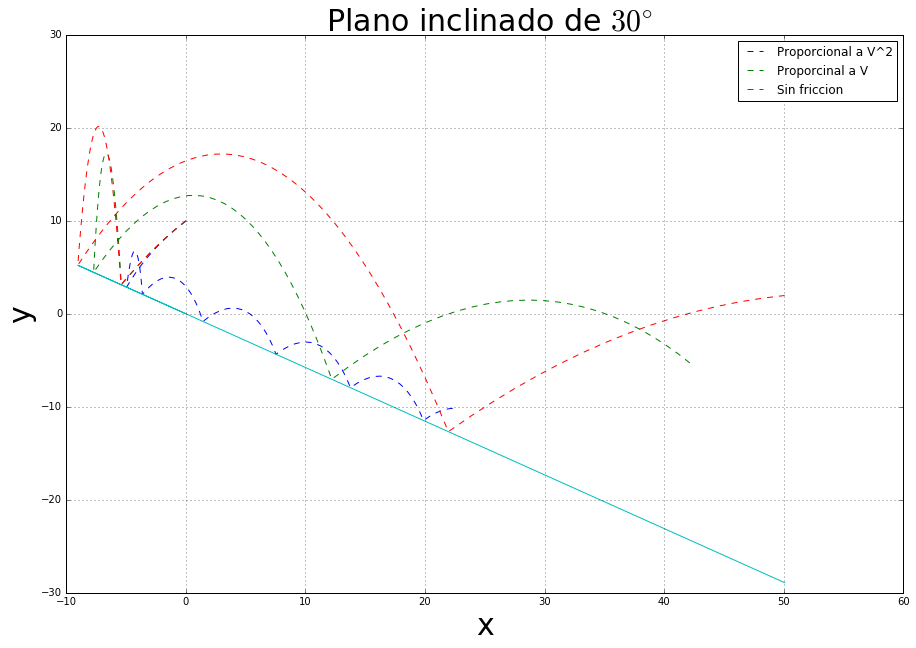

In [117]:
fig, ax = plt.subplots(figsize=(15, 10))
grid(True)
title(r' Plano inclinado de $30^{\circ}$',fontsize = 30),xlabel('x',fontsize=30),ylabel('y',fontsize = 30)

modelos = [0 , fric_v, fric_v2]
etiquetas = ['Sin friccion','Proporcinal a V','Proporcional a V^2']

for i in xrange(len(modelos)):
    trayectoria = datos_graf([0,10,-10,-10],30,modelos[2-i])
    plot(trayectoria[:,0],trayectoria[:,1],'--',label = str(etiquetas[2-i]))
plot(trayectoria[:,0],plano(trayectoria[:,0],30))
ax.legend(loc='upper right')
show()

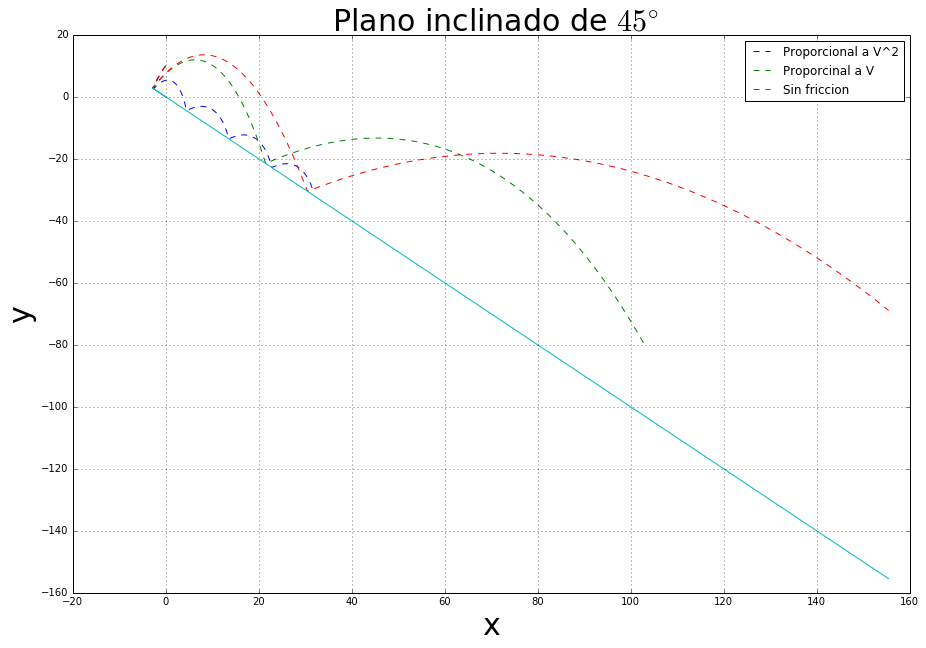

In [123]:
fig, ax = plt.subplots(figsize=(15, 10))
grid(True)
title(r' Plano inclinado de $45^{\circ}$',fontsize = 30),xlabel('x',fontsize=30),ylabel('y',fontsize = 30)

modelos = [0 , fric_v, fric_v2]
etiquetas = ['Sin friccion','Proporcinal a V','Proporcional a V^2']

for i in xrange(len(modelos)):
    trayectoria = datos_graf([0,10,-5,-10],45,modelos[2-i])
    plot(trayectoria[:,0],trayectoria[:,1],'--',label = str(etiquetas[2-i]))
plot(trayectoria[:,0],plano(trayectoria[:,0],45))
ax.legend(loc='upper right')
show()